In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# DistilBERT

In [ ]:
! pip install --quiet lightning
! pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 27.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
# importing all necessary packages
from os import listdir
from os.path import join
from sklearn.model_selection import train_test_split
import string
from torch.utils.data import Dataset, DataLoader
import torch
import torchmetrics
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from transformers import DistilBertTokenizer

#### Dataset Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#show dataframe
train_data_preprocessed = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/kaggle_preprocessed.csv')
train_data_preprocessed.head()

,text,label,%unique_word_total,%stop_word_total,mean_word_length,mean_char_count_per_word
0,carfree cities become subject increasing inter...,1,0.466087,0.340870,5.926957,6.925217
1,car free cities carfree cities concept gaining...,1,0.518519,0.309942,6.111111,7.109162
2,sustainable urban future carfree cities emergi...,1,0.492188,0.302734,6.265625,7.265625
3,pioneering sustainable urban living era marked...,1,0.495183,0.333333,6.015414,7.015414
4,path sustainable urban living age rapid urbani...,1,0.481409,0.315068,6.039139,7.039139


In [ ]:
train_data_preprocessed.shape

(27340, 6)

In [ ]:
#show dataframe
test_data_preprocessed = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv')
test_data_preprocessed.head()

,text,label,%unique_word_total,%stop_word_total,mean_word_length,mean_char_count_per_word
0,marshall plan test progress test progress whet...,0,0.444112,0.392216,5.384232,6.384232
1,promoting global regional security postcold wa...,0,0.414807,0.424949,5.150101,6.150101
2,womanhood peacemaking taking advantage unity c...,0,0.475947,0.378710,5.583419,6.583419
3,human rights universal western construct cruci...,0,0.370482,0.503012,4.875502,5.875502
4,challenges american foreign service rebuilding...,0,0.467425,0.379524,5.668046,6.668046


In [ ]:
from sklearn.model_selection import train_test_split
#show shape of train and test set
df_train, df_validation = train_test_split(train_data_preprocessed, test_size=0.3, random_state=42)
df_test = test_data_preprocessed # rename

print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)
df_train.dropna(inplace = True)
df_validation.dropna(inplace = True)
df_test.dropna(inplace = True)
print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

(19138, 6)
(8202, 6)
(40, 6)
(19137, 6)
(8202, 6)
(40, 6)


In [ ]:
# Prepare for DataLoader and Dataset without converting labels to ordinal
X_train_token_list = []
X_val_token_list = []
X_test_token_list = []
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Process the data
for i in df_train["text"]:
    X_train_token_list.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))
for i in df_validation["text"]:
    X_val_token_list.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))
for i in df_test["text"]:
    X_test_token_list.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# add labels to token_list for use later as dataset
train_labels = []
for i in df_train["label"]:
  if int(i) == 0:
    train_labels.append(0)
  else:
    train_labels.append(1)
val_labels = []
for i in df_validation["label"]:
  if int(i) == 0:
    val_labels.append(0)
  else:
    val_labels.append(1)
test_labels = []
for i in df_test["label"]:
  if int(i) == 0:
    test_labels.append(0)
  else:
    test_labels.append(1)
for i in range(len(X_train_token_list)):
  X_train_token_list[i]["label"] = torch.tensor(train_labels[i])
for i in range(len(X_val_token_list)):
  X_val_token_list[i]["label"] = torch.tensor(val_labels[i])
for i in range(len(X_test_token_list)):
  X_test_token_list[i]["label"] = torch.tensor(test_labels[i])


In [ ]:
# show our input data
print(X_train_token_list[1])

{'input_ids': tensor([[  101,  6203,  3836, 18442,  3047,  1996,  2869,  2724,  4550,  2451,
          2326,  2157,  2157,  2518,  2451,  2326,  2590,  2451,  2925,  2451,
          2689,  7955,  3407,  2111,  2987,  2102, 10587,  4783,  2393,  2477,
          2518,  2082,  2493,  2451,  2326,  2034,  3114,  2451,  2326,  2590,
          3664,  2103,  7098,  2111,  2360,  6752,  2451,  2326,  2272,  2393,
          2187, 11669,  2101,  5437,  2919,  2111,  6283,  3047,  3531,  2123,
          2102,  2681, 27042,  2723,  2404, 11669,  2117,  3114,  2045,  2015,
          2724,  2111,  2147,  4550,  2724,  4627,  2111,  2228,  3138,  2172,
          2051,  2185,  2215,  2393,  2111,  2451,  2082,  2518,  2814,  2987,
          2102,  2215,  2393,  2197,  3114,  2045,  2015,  2172,  4550,  2305,
          5553, 27287,  2342,  4550,  2305,  2279,  2154,  3310,  4550, 15708,
          2111,  4550,  4933,  2894,  2823,  2362,  2228,   102,     0,     0,
             0,     0,     0,     0,  

In [ ]:
# Create dataset and dataloader
class MyDataset(Dataset):
    def __init__(self, array_of_dicts):
        self.data = array_of_dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

trainset = MyDataset(X_train_token_list)
valset = MyDataset(X_val_token_list)
testset = MyDataset(X_test_token_list)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    dataset=valset,
    batch_size=4,
    num_workers=0
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=4,
    num_workers=0
)

In [ ]:
# train our model and freeze our parameter
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

for param in model.parameters():
    param.requires_grad = False

for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

#model structure
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate=5e-5):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        # Ensure the config is set
        self.config = model.config  # Copy the model's configuration

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.train_auroc = torchmetrics.AUROC(task="multiclass", num_classes=2)  # AUROC for training


        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_auroc = torchmetrics.AUROC(task="multiclass", num_classes=2)  # AUROC for evaluation
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_auroc = torchmetrics.AUROC(task="multiclass", num_classes=2)  # AUROC for testing

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"].squeeze(1), attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        self.log("train_loss", outputs["loss"])
        logits = outputs["logits"]
        probabilities = torch.softmax(logits, dim=1)  # Get probabilities for the positive class
        predicted_labels = torch.argmax(logits, 1)

        # Log accuracy
        self.train_acc(predicted_labels, batch["label"])
        self.log("train_acc", self.train_acc)

        # Update and log AUROC for training
        self.train_auroc(probabilities, batch["label"])
        # self.train_auroc.update(probabilities[:, 1], batch["label"])  # Use probabilities for the positive class
        self.log("train_auroc", self.train_auroc)

        return outputs["loss"]

    def validation_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"].squeeze(1), attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        self.log("val_loss", outputs["loss"], prog_bar=True)

        logits = outputs["logits"]
        probabilities = torch.softmax(logits, dim=1)  # Get probabilities
        predicted_labels = torch.argmax(logits, 1)

        # Log accuracy
        self.val_acc(predicted_labels, batch["label"])
        self.log("val_acc", self.val_acc, prog_bar=True)

        # Update and log AUROC
        self.val_auroc(probabilities, batch["label"])
        # self.val_auroc.update(probabilities[:, 1], batch["label"])  # Use probabilities for the positive class
        self.log("val_auroc", self.val_auroc, prog_bar=True)

        # output for classification report
        return {"logits": logits, "loss": outputs["loss"], "labels": batch["label"]}

    def test_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"].squeeze(1), attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        self.log("test_loss", outputs["loss"], prog_bar=True)

        logits = outputs["logits"]
        probabilities = torch.softmax(logits, dim=1)  # Get probabilities
        predicted_labels = torch.argmax(logits, 1)

        # Log accuracy
        self.test_acc(predicted_labels, batch["label"])
        self.log("accuracy", self.test_acc, prog_bar=True)

        # Update and log AUROC
        self.test_auroc(probabilities, batch["label"])
        self.log("test_auroc", self.test_auroc, prog_bar=True)

        # output for classification report
        return {"logits": logits, "loss": outputs["loss"], "labels": batch["label"]}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


lightning_model = LightningModel(model)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Change the monitor to "val_auroc"
logger = TensorBoardLogger("distilbert-add-fea/", name="finetuning", version="original")
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_auroc"  # Monitor the AUROC metric
    )
]

In [ ]:
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=callbacks,
    # accelerator="gpu",  uncomment if gpu available
    devices=1,
    logger=logger,
    log_every_n_steps=1,
)

# Start training
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                                | Params
--------------------------------------------------------------------
0 | model       | DistilBertForSequenceClassification | 67.0 M
1 | train_acc   | MulticlassAccuracy                  | 0     
2 | train_auroc | MulticlassAUROC                     | 0     
3 | val_acc     | MulticlassAccuracy                  | 0     
4 | val_auroc   | MulticlassAUROC                     | 0     
5 | test_acc    | MulticlassAccuracy                  | 0     
6 | test_auroc  | MulticlassAUROC  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
# Define the path to save the model
model_path = "/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/distilbert/latest/distilbert-dataset-v3-kaggle30k_ep3_dropout0.4.pth"

# Save the entire model
torch.save(lightning_model, model_path)

In [ ]:
# test with validation dataset
val_results = trainer.validate(lightning_model, dataloaders=val_loader, ckpt_path="best")
val_results

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at distilbert-add-fea/finetuning/original/checkpoints/epoch=2-step=14355.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at distilbert-add-fea/finetuning/original/checkpoints/epoch=2-step=14355.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9826871752738953     │
│         val_auroc         │     0.997776985168457     │
│         val_loss          │    0.05283687263727188    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.05283687263727188,
  'val_acc': 0.9826871752738953,
  'val_auroc': 0.997776985168457}]

In [ ]:
test_results = trainer.test(lightning_model, dataloaders=test_loader, ckpt_path="best")
test_results

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at distilbert-add-fea/finetuning/original/checkpoints/epoch=2-step=14355.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at distilbert-add-fea/finetuning/original/checkpoints/epoch=2-step=14355.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.675000011920929     │
│        test_auroc         │    0.8849999904632568     │
│         test_loss         │     1.35210382938385      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.35210382938385,
  'accuracy': 0.675000011920929,
  'test_auroc': 0.8849999904632568}]

### Domain Adaptation: Transfer Learning with New Dataset

In [ ]:
train_data_preprocessed_ft2= pd.read_csv('../Data/new_essay_train_preprocessed.csv')
print(train_data_preprocessed_ft2.shape)
train_data_preprocessed_ft2.head()

(60, 6)


,text,label,%unique_word_total,%stop_word_total,mean_word_length,mean_char_count_per_word
0,strategic collaboration constructive communica...,0,0.479633,0.353360,5.606925,6.605906
1,united states china powerful combination ameri...,0,0.442183,0.443108,4.779833,5.778908
2,911 foreign service contributions shortterm re...,0,0.539461,0.318681,5.623377,6.623377
3,2002 united nations un secretarygeneral kofi a...,0,0.544498,0.362679,5.744498,6.744498
4,awakening witness empowering engagement levera...,0,0.492711,0.345967,5.464529,6.464529


In [ ]:
######
df_train_ft2, df_val_ft2 = train_test_split(train_data_preprocessed_ft2, test_size=0.3, random_state=42)
print(df_train_ft2.shape)
print(df_val_ft2.shape)
df_train_ft2.dropna(inplace = True)
df_val_ft2.dropna(inplace = True)
print(df_train_ft2.shape)
print(df_val_ft2.shape)

(42, 6)
(18, 6)
(42, 6)
(18, 6)


In [ ]:
# Prepare for DataLoader and Dataset without converting labels to ordinal
X_train_token_list_ft2 = []
X_val_token_list_ft2 = []
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Process the data
for i in df_train_ft2["text"]:
    X_train_token_list_ft2.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))
for i in df_val_ft2["text"]:
    X_val_token_list_ft2.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))

# add labels to token_list for use later as dataset
train_labels = []
for i in df_train_ft2["label"]:
  if int(i) == 0:
    train_labels.append(0)
  else:
    train_labels.append(1)
val_labels = []
for i in df_val_ft2["label"]:
  if int(i) == 0:
    val_labels.append(0)
  else:
    val_labels.append(1)

for i in range(len(X_train_token_list_ft2)):
  X_train_token_list_ft2[i]["label"] = torch.tensor(train_labels[i])
for i in range(len(X_val_token_list_ft2)):
  X_val_token_list_ft2[i]["label"] = torch.tensor(val_labels[i])

# # add additoinal features to token_list for use later as dataset
# for i in range(len(X_train_token_list_ft2)):
#     row = df_train_ft2.iloc[i]
#     X_train_token_list_ft2[i]['%unique_word_total'] = row['%unique_word_total'].astype(np.float32)
#     X_train_token_list_ft2[i]['%stop_word_total'] = row['%stop_word_total'].astype(np.float32)
#     X_train_token_list_ft2[i]['mean_word_length'] = row['mean_word_length'].astype(np.float32)
#     X_train_token_list_ft2[i]['mean_char_count_per_word'] = row['mean_char_count_per_word'].astype(np.float32)

# for i in range(len(X_val_token_list_ft2)):
#     row = df_val_ft2.iloc[i]
#     X_val_token_list_ft2[i]['%unique_word_total'] = row['%unique_word_total'].astype(np.float32)
#     X_val_token_list_ft2[i]['%stop_word_total'] = row['%stop_word_total'].astype(np.float32)
#     X_val_token_list_ft2[i]['mean_word_length'] = row['mean_word_length'].astype(np.float32)
#     X_val_token_list_ft2[i]['mean_char_count_per_word'] = row['mean_char_count_per_word'].astype(np.float32)

In [ ]:
trainset_ft2 = MyDataset(X_train_token_list_ft2)
valset_ft2 = MyDataset(X_val_token_list_ft2)

# Create new DataLoaders for the new datasets
train_loader_ft2 = DataLoader(
    dataset=trainset_ft2,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

val_loader_ft2 = DataLoader(
    dataset=valset_ft2,
    batch_size=4,
    num_workers=0
)

In [ ]:
# Change the monitor to "val_auroc"
logger = TensorBoardLogger("distilbert-add-fea/", name="finetuning", version="original")
callbacks = [
    ModelCheckpoint(
        save_top_k=1, mode="max", monitor="val_auroc"  # Monitor the AUROC metric
    )
]

In [ ]:
# from pytorch_lightning import LightningModule

# model_path = "../distilbert-dataset-v3-kaggle30k_ep3_dropout0.4.pth"

# # Load the model
# loaded_model = torch.load(model_path)

# print("Model loaded.")

Model loaded.


In [ ]:
# Define the PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=callbacks,
    devices=1,
    logger=logger,
    log_every_n_steps=1,
)

# Continue training with the loaded model (finetuned v1) with the new dataset
trainer.fit(
    model=loaded_model,
    train_dataloaders=train_loader_ft2,
    val_dataloaders=val_loader_ft2
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type                                | Params
--------------------------------------------------------------------
0 | model       | DistilBertForSequenceClassification | 67.0 M
1 | train_acc   | MulticlassAccuracy                  | 0     
2 | train_auroc | MulticlassAUROC                     | 0     
3 | val_acc     | MulticlassAccuracy                  | 0     
4 | val_auroc   | MulticlassAUROC                     | 0     
5 | test_acc    | MulticlassAccuracy                  | 0     
6 | test_auroc  | MulticlassAUROC                     | 0     
--------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
# test with validation dataset
val_results = trainer.validate(loaded_model, dataloaders=val_loader_ft2, ckpt_path="best")
val_results

Restoring states from the checkpoint path at distilbert-add-fea/finetuning/original/checkpoints/epoch=0-step=11.ckpt
Loaded model weights from the checkpoint at distilbert-add-fea/finetuning/original/checkpoints/epoch=0-step=11.ckpt


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7222222089767456
        val_auroc           0.9125000238418579
        val_loss            1.0227278470993042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.0227278470993042,
  'val_acc': 0.7222222089767456,
  'val_auroc': 0.9125000238418579}]

#### Test Data for Finetuning Round 2 (Using the Same Dataset)

In [ ]:
# test with unseen test dataset (same test dataset as finetuning round 1)
test_results = trainer.test(loaded_model, dataloaders=test_loader, ckpt_path="best")
test_results

Restoring states from the checkpoint path at distilbert-add-fea/finetuning/original/checkpoints/epoch=0-step=11.ckpt


Loaded model weights from the checkpoint at distilbert-add-fea/finetuning/original/checkpoints/epoch=0-step=11.ckpt


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy             0.675000011920929
       test_auroc           0.8849999904632568
        test_loss           0.8044333457946777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8044333457946777,
  'accuracy': 0.675000011920929,
  'test_auroc': 0.8849999904632568}]

### Classification report with Deployment Test Dataset

In [ ]:
#load the deployment test dataset

df_test_final = pd.read_csv('../Data/test_data_preprocessed.csv')
print(df_test_final.shape)
df_test_final.dropna(inplace = True)
print(df_test_final.shape)
df_test_final.head()

(50, 6)
(50, 6)


,text,label,%unique_word_total,%stop_word_total,mean_word_length,mean_char_count_per_word
0,new century daunting number important issues c...,0,0.505506,0.443443,5.159159,6.158158
1,many associate word courage comic book stereot...,0,0.470000,0.452000,4.693000,5.692000
2,complex landscape 21stcentury politics multitu...,1,0.531938,0.395374,5.730176,6.729075
3,pantheon heroism many idolize largerthanlife f...,1,0.504523,0.447236,5.148744,6.147739
4,americans rewritten declaration independence t...,0,0.465932,0.397796,5.256513,6.255511


In [ ]:
# Create dataset and dataloader
class MyDataset(Dataset):
    def __init__(self, array_of_dicts):
        self.data = array_of_dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item


X_test_token_list = []
for i in df_test_final["text"]:
    X_test_token_list.append(tokenizer(i, truncation=True, padding='max_length', max_length=512, return_tensors='pt'))

test_labels = []
for i in df_test_final["label"]:
  if int(i) == 0:
    test_labels.append(0)
  else:
    test_labels.append(1)

for i in range(len(X_test_token_list)):
  X_test_token_list[i]["label"] = torch.tensor(test_labels[i])


# for i in range(len(X_test_token_list)):
#     row = df_test_final.iloc[i]
#     X_test_token_list[i]['%unique_word_total'] = row['%unique_word_total'].astype(np.float32)
#     X_test_token_list[i]['%stop_word_total'] = row['%stop_word_total'].astype(np.float32)
#     X_test_token_list[i]['mean_word_length'] = row['mean_word_length'].astype(np.float32)
#     X_test_token_list[i]['mean_char_count_per_word'] = row['mean_char_count_per_word'].astype(np.float32)


testset_final = MyDataset(X_test_token_list)
test_loader_final = DataLoader(
    dataset=testset_final,
    batch_size=4,
    num_workers=0
)

In [ ]:
import pytorch_lightning as pl
import torch
from sklearn.metrics import classification_report
import numpy as np

# Define a callback to collect test results
class CollectTestOutputsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.test_outputs = []  # List to store outputs

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Collect the outputs from each test batch
        self.test_outputs.append(outputs)  # Store the outputs from test_step


# Create the callback
collect_test_outputs_callback = CollectTestOutputsCallback()

# Initialize the trainer with the callback
trainer = pl.Trainer(callbacks=[collect_test_outputs_callback])

# Run test
trainer.test(lightning_model, dataloaders=test_loader_final)

# Get the collected test outputs
test_outputs = collect_test_outputs_callback.test_outputs

# Concatenate logits and labels from collected outputs
all_logits = []
all_labels = []
for output in test_outputs:
    all_logits.extend(output["logits"].tolist())
    all_labels.extend(output["labels"].tolist())

print("Logits:", all_logits)
print("Labels:", all_labels)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: /Users/zheng/Downloads/Validation/Submission/lightning_logs


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy            0.8399999737739563
       test_auroc           0.9408000111579895
        test_loss           0.3070887327194214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Logits: [[-0.37243086099624634, 0.3630355894565582], [3.184626817703247, -3.194509983062744], [-5.281475067138672, 5.279506206512451], [-0.9095499515533447, 0.9050537347793579], [1.1538922786712646, -1.1782474517822266], [-1.1007648706436157, 1.0797852277755737], [1.8524020910263062, -1.8784444332122803], [-2.104428768157959, 2.062283992767334], [0.6490978598594666, -0.6328340172767639], [-1.0086555480957031, 1.0098612308502197], [1.277713775634765

In [ ]:
!pip --quiet install scikit-learn

In [ ]:
import torch
import pytorch_lightning as pl
import numpy as np
from sklearn.metrics import classification_report

# Collect predictions and true labels
predicted_labels = []
true_labels = []
for result in test_outputs:
    if "logits" in result and "labels" in result:
        predicted_labels.extend(torch.argmax(result["logits"], 1).tolist())
        true_labels.extend(result["labels"].tolist())

# Generate the classification report
classification_rep = classification_report(
    true_labels, predicted_labels, target_names=["Class 0", "Class 1"]  # Adjust target names as needed
)

print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.88      0.85        25
     Class 1       0.87      0.80      0.83        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[22  3]
 [ 5 20]]


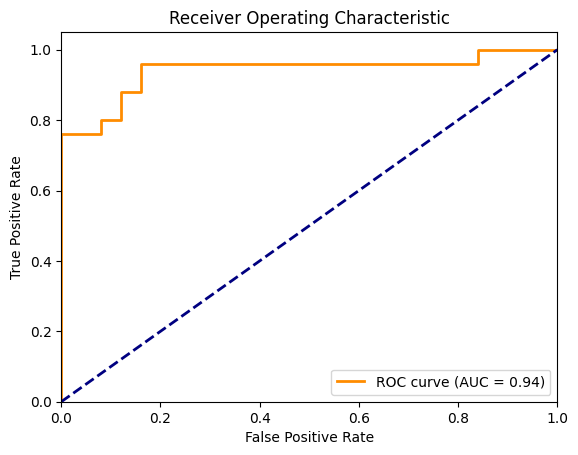

Optimal threshold: 0.24125228822231293


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Assuming validation_outputs contain the logits and true labels
predicted_probabilities = []
true_labels = []

for result in test_outputs:
    if "logits" in result and "labels" in result:
        logits = result["logits"]
        probabilities = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        positive_class_probability = probabilities[:, 1].tolist()  # Get probabilities for positive class

        predicted_probabilities.extend(positive_class_probability)  # Append probabilities
        true_labels.extend(result["labels"].tolist())  # Append true labels

# Convert to numpy arrays
predicted_probabilities = np.array(predicted_probabilities)
true_labels = np.array(true_labels)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)  # Area under the ROC curve

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)  # Diagonal line for random guess
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Finding the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Index where TPR - FPR is maximized
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")